In [1]:
!nvidia-smi

Thu Oct 19 06:20:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q --upgrade transformers diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.6 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as tfms
import torchvision.transforms.functional as FT
import torchvision.models as models

from PIL import Image
import numpy
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from diffusers import StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer, logging

import random
from tqdm import tqdm
import os
import subprocess

from matplotlib import pyplot as plt
from pathlib import Path
from torch import autocast
from tqdm.auto import tqdm
# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!cp -r '/content/gdrive/My Drive/ERA1/s20_stable_diffusion' '.'

In [6]:
# Define a function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path)
    preprocess = tfms.Compose([
        tfms.Resize((512, 512)),
        tfms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image).unsqueeze(0)
    return image

# Load a reference image and a generated image
reference_image = load_image("/content/s20_stable_diffusion/Val_Data/Winged Drones/wd7.jpg").to('cuda')

# Load a pre-trained VGG model (you can use other models as well)
vgg_model = models.vgg16(pretrained=True).features
vgg_model = vgg_model.to('cuda')

# Define the layers from which to extract features
feature_layers = ["0", "5", "10", "19", "28", "30"]  # These layers capture high-level features

# Create a new model that extracts features from the chosen layers
feature_extractor = nn.Sequential()
for name, layer in vgg_model._modules.items():
    if name == '0':  # Stop at the 28th layer
        break
    feature_extractor.add_module(name, layer)

r_img_extr = feature_extractor(reference_image)
r_img_extr.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s]


torch.Size([1, 3, 512, 512])

# Huggingface

In [7]:
pretrained_model_name_or_path = "segmind/tiny-sd"
pipe = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float32
).to("cuda")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

unet/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = pipe.vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()  # [1, 4, 64, 64]

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [9]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

def pattern_loss(images, pattern):
    """
    This function calculates the pattern loss between the output image and the desired pattern.

    Parameters:
    images (torch.Tensor): The output image generated by the Huggingface model.
    pattern (torch.Tensor): The desired pattern that the output image should follow. This is extracted from a pre-trained model in above steps.

    Returns:
    torch.Tensor: The pattern loss between the output image and the desired pattern.
    """
    # Calculate the absolute difference between the model predicetd image and the pattern extracted from pre-trained model(above step).
    diff = torch.abs(images - pattern)
    # Sum the difference over all channels and pixels.
    loss = torch.sum(diff)
    return loss

def perceptual_loss(images, pattern):
    """
    This function calculates the perceptual loss between the output image and the target image.

    Parameters:
    """
    criterion = nn.MSELoss()
    mse_loss = criterion(images, pattern)
    return mse_loss

In [10]:
#Generating image with the modified embeddings with pattern loss guidance and saving the images to steps/{concept} folder
def generate_with_embs_pattern_loss(prompt, concept_seed, concept):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 200          # Number of denoising steps
    guidance_scale = 8                  # Scale for classifier-free guidance
    generator = torch.manual_seed(concept_seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    pattern_loss_scale = 20
    blue_loss_scale = 200


    text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)
    with torch.no_grad():
        text_embeddings = pipe.text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = pipe.tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn((batch_size, pipe.unet.in_channels, height // 8, width // 8),
                           generator=generator,)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG (Classifier Free Guidance)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        if i%2 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = pipe.vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
            # Calculate loss
            # loss = blue_loss(denoised_images) * blue_loss_scale
            denoised_images_extr = feature_extractor(denoised_images)
            reference_img_extr = feature_extractor(reference_image)
            # loss = pattern_loss(denoised_images, pattern) * pattern_loss_scale
            # loss = pattern_loss(denoised_images_extr, reference_img_extr) * pattern_loss_scale
            loss = perceptual_loss(denoised_images_extr, reference_img_extr) * pattern_loss_scale
            # Occasionally print it out
            if i%30==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler. compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

        if (i%49 == 0) or (i == (num_inference_steps-1)):

            # To PIL Images
            im_t0 = latents_to_pil(latents_x0)[0]
            im_next = latents_to_pil(latents)[0]

            # Combine the two images and save for later viewing
            im = Image.new('RGB', (1024, 512))
            im.paste(im_next, (0, 0))
            im.paste(im_t0, (512, 0))
            im.save(f'steps/{concept}/{i:04}.jpeg')

        if i%449 == 0:
            im_l = Image.new('RGB', (512, 512))
            im_last = latents_to_pil(latents)[0]
            im_l.paste(im_last, (0, 0))
            im_l.save(f'steps/{concept}/{i:04}_Final.jpeg')

    return latents_to_pil(latents)[0]

In [11]:
!rm -rf '/content/steps'

In [12]:
directories = ['anime_bg_v2', 'birb', 'depthmap', 'gta5_artwork', 'midjourney', 'beetlejuice']

# Remove the style folders to save the diffuser output images, if they already exists
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    cmd = f"rm -rf {dir_path}"
    output = subprocess.check_output(cmd, shell=True)

# Remove the style folders to save the diffuser output images, if they already exists
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    # construct the shell command to remove the directory
    if os.path.isdir(dir_path):
        os.rmdir(dir_path)
        print(f' Removed - {dir_path}')
    else:
        print(f' Doesnt exist - {dir_path}')

if os.path.exists('/content/steps'):
    print(f'/content/steps exists')
else:
    os.mkdir('/content/steps')
    print(f'Created /content/steps')
    os.mkdir('/content/steps/images_no_loss')
    print(f'Created /content/steps/images_no_loss')

# Create the style folders to save the diffuser output images
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    # construct the shell command to remove the directory
    if os.path.exists(dir_path):
        print(f' Already exists - {dir_path}')
    else:
        os.mkdir(dir_path)
        print(f' Created - {dir_path}')

 Doesnt exist - /content/steps/anime_bg_v2
 Doesnt exist - /content/steps/birb
 Doesnt exist - /content/steps/depthmap
 Doesnt exist - /content/steps/gta5_artwork
 Doesnt exist - /content/steps/midjourney
 Doesnt exist - /content/steps/beetlejuice
Created /content/steps
Created /content/steps/images_no_loss
 Created - /content/steps/anime_bg_v2
 Created - /content/steps/birb
 Created - /content/steps/depthmap
 Created - /content/steps/gta5_artwork
 Created - /content/steps/midjourney
 Created - /content/steps/beetlejuice


In [13]:
concept_dict={'anime_bg_v2':('sd-concepts-library/anime-background-style-v2','<anime-background-style-v2>',31),
              'birb':('sd-concepts-library/birb-style','<birb-style>',32),
              'depthmap':('sd-concepts-library/depthmap','<depthmap>',33),
              'gta5_artwork':('sd-concepts-library/gta5-artwork','<gta5_artwork>',34),
              'midjourney':('sd-concepts-library/midjourney-style','<midjourney-style>',35),
              'beetlejuice':('sd-concepts-library/beetlejuice-cartoon-style','<beetlejuice-cartoon>',36)}

- Reference Image

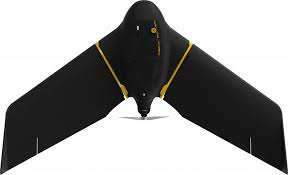

In [14]:
Image.open('/content/s20_stable_diffusion/Val_Data/Winged Drones/wd7.jpg')

In [15]:
# Generating images with pattern loss with style. num_inference_steps = 200
suffix_prompt = 'A boy running in the style of '

for concept, value in concept_dict.items():
    concept_embed_loc, concept_key, concept_seed = value
    print(f'concept_embed_loc : {concept_embed_loc} concept_key : {concept_key}, concept_seed : {concept_seed}, concept : {concept} ')
    pipe.load_textual_inversion(concept_embed_loc)
    prompt = f'{suffix_prompt} {concept_key}'
    print(prompt)
    # image = pipe(prompt, num_inference_steps=50).images[0]
    # image.save('image_test.png')
    # # concept_output_embeddings, text_input = get_modified_output_embeddings(prompt, concept_key, repl_token_num)
    generated_img = generate_with_embs_pattern_loss(prompt, concept_seed, concept)

concept_embed_loc : sd-concepts-library/anime-background-style-v2 concept_key : <anime-background-style-v2>, concept_seed : 31, concept : anime_bg_v2 
A boy running in the style of  <anime-background-style-v2>


<ipython-input-10-b3cc8f1fd5e2>:28: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, pipe.unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 3.943471908569336
30 loss: 3.9534246921539307
60 loss: 2.78326416015625
90 loss: 2.3779046535491943
120 loss: 2.3773159980773926
150 loss: 2.3915884494781494
180 loss: 2.407252788543701
concept_embed_loc : sd-concepts-library/birb-style concept_key : <birb-style>, concept_seed : 32, concept : birb 
A boy running in the style of  <birb-style>


0it [00:00, ?it/s]

0 loss: 4.547379016876221
30 loss: 2.715411424636841
60 loss: 2.196017265319824
90 loss: 1.9539437294006348
120 loss: 1.8947970867156982
150 loss: 1.8474817276000977
180 loss: 1.8334736824035645
concept_embed_loc : sd-concepts-library/depthmap concept_key : <depthmap>, concept_seed : 33, concept : depthmap 
A boy running in the style of  <depthmap>


0it [00:00, ?it/s]

0 loss: 6.707557678222656
30 loss: 4.492335796356201
60 loss: 3.318446636199951
90 loss: 2.7269279956817627
120 loss: 2.633695602416992
150 loss: 2.615168571472168
180 loss: 2.625866174697876
concept_embed_loc : sd-concepts-library/gta5-artwork concept_key : <gta5_artwork>, concept_seed : 34, concept : gta5_artwork 
A boy running in the style of  <gta5_artwork>


0it [00:00, ?it/s]

0 loss: 4.227950572967529
30 loss: 1.852432370185852
60 loss: 1.2950849533081055
90 loss: 1.2168806791305542
120 loss: 1.1986631155014038
150 loss: 1.2283949851989746
180 loss: 1.259637475013733
concept_embed_loc : sd-concepts-library/midjourney-style concept_key : <midjourney-style>, concept_seed : 35, concept : midjourney 
A boy running in the style of  <midjourney-style>


0it [00:00, ?it/s]

0 loss: 5.856328010559082
30 loss: 3.9229345321655273
60 loss: 2.6150364875793457
90 loss: 2.077822208404541
120 loss: 1.979190707206726
150 loss: 1.9539600610733032
180 loss: 1.9534327983856201
concept_embed_loc : sd-concepts-library/beetlejuice-cartoon-style concept_key : <beetlejuice-cartoon>, concept_seed : 36, concept : beetlejuice 
A boy running in the style of  <beetlejuice-cartoon>


0it [00:00, ?it/s]

0 loss: 3.148250102996826
30 loss: 4.036118507385254
60 loss: 2.6832544803619385
90 loss: 2.4474704265594482
120 loss: 2.62933611869812
150 loss: 2.901686429977417
180 loss: 3.0493826866149902


# PROMPT : 'A boy running in the style of a tiger'
- 6 Different styles with percpetual loss gudiance

In [16]:
!mkdir '/content/steps/images_pattern_loss'

In [ ]:
!cp '/content/steps/anime_bg_v2/0199.jpeg' '/content/steps/images_pattern_loss/anime_bg_v2_final.jpeg'
!cp '/content/steps/birb/0199.jpeg' '/content/steps/images_pattern_loss/birb_final.jpeg'
!cp '/content/steps/depthmap/0199.jpeg' '/content/steps/images_pattern_loss/depthmap_final.jpeg'
!cp '/content/steps/gta5_artwork/0199.jpeg' '/content/steps/images_pattern_loss/gta5_artwork_final.jpeg'
!cp '/content/steps/midjourney/0199.jpeg' '/content/steps/images_pattern_loss/midjourney_final.jpeg'
!cp '/content/steps/beetlejuice/0199.jpeg' '/content/steps/images_pattern_loss/beetlejuice_final.jpeg'

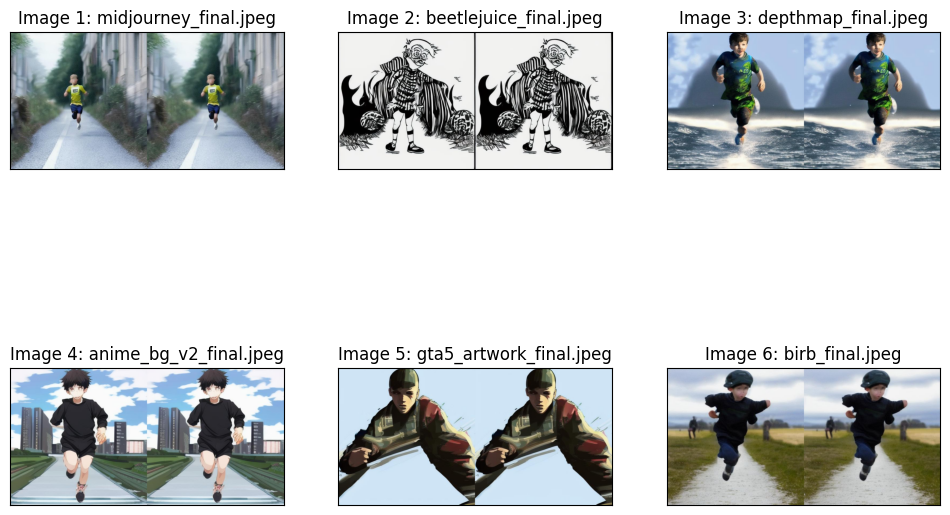

In [19]:
# Displaying images that were generated for 5 different styles with pattern loss guidnace
# define the folder path where the images are located
folder_path = '/content/steps/images_pattern_loss'

# get the list of image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpeg')]

# create a new figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the image files and plot them in the subplot
for i, file in enumerate(image_files[:6]):
    # open the image file using Pillow
    image = Image.open(file)

    # get the current subplot
    ax = axs[i//3, i%3]

    # plot the image
    ax.imshow(image)

    # set the title of the subplot to the image file name
    ax.set_title(f'Image {i+1}: {os.path.basename(file)}')

# hide the x and y axis ticks of the subplots
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# display the subplots
plt.show()